# 1) Backpropagation Fundamentals

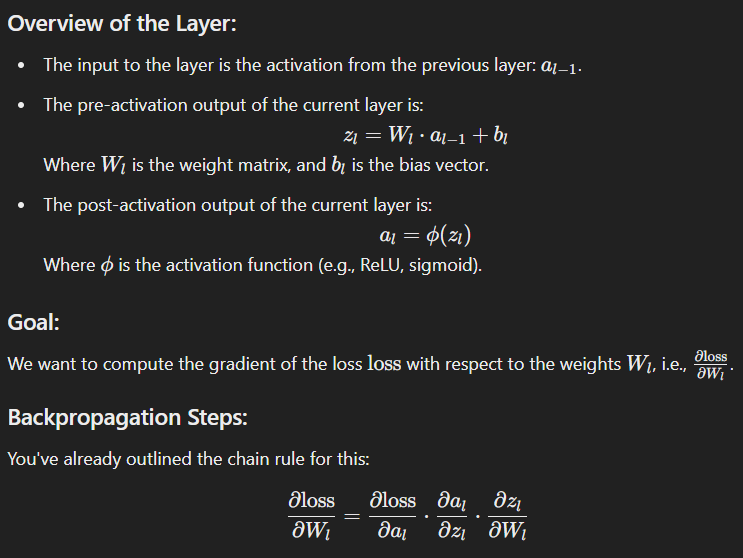

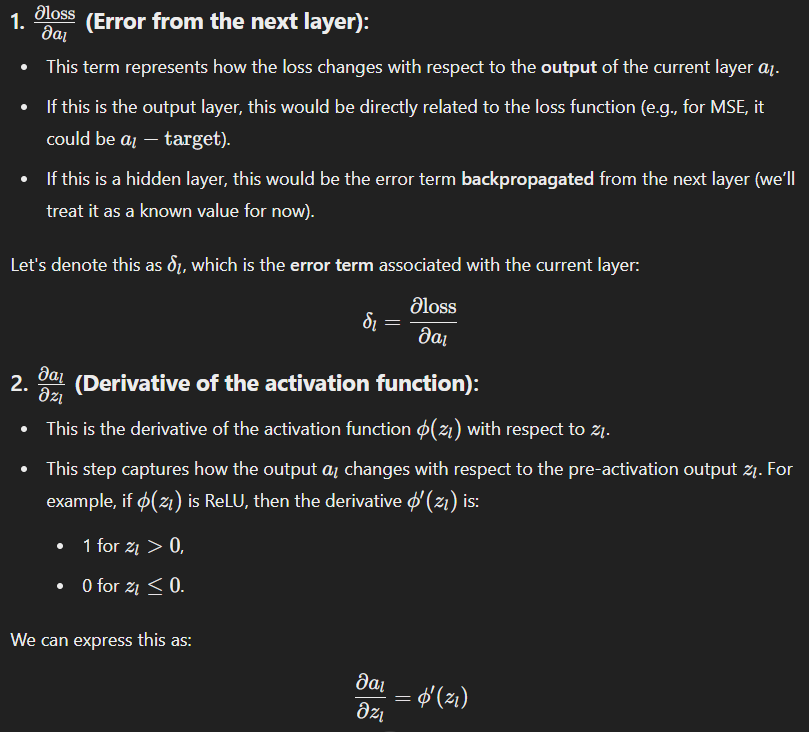

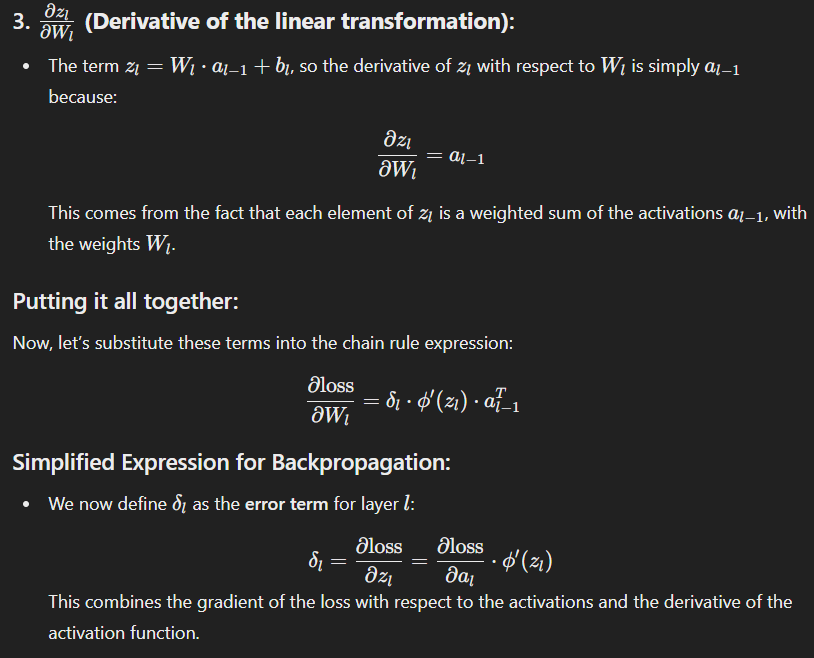

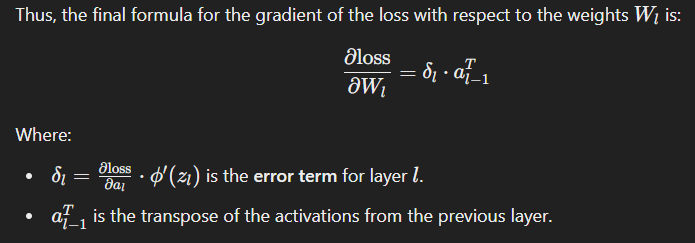

## 1.1) Data Preparation

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# download the names.txt file from github
# !wget https://raw.githubusercontent.com/Paradox3333/0-to-transformers/main/names.txt

In [60]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [61]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [62]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# 2) Neural Net Setup

In [ ]:
# utility function to compare manual gradients to PyTorch gradients
def cmp(s: str, dt: float, t: torch.tensor) -> None:
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [ ]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# NOTE: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [65]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [ ]:
# forward pass, "chunked" into smaller steps that are possible to backward through one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # NOTE: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer activation
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True) # Sum of exponentials for each row (denominator for Softmax).
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv # Softmax
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss


tensor(3.3205, grad_fn=<NegBackward0>)

## Exercise 1: Backpropagation Step-by-Step

In [ ]:
# Longer explanations (for grad calculations):
# https://www.youtube.com/watch?v=q8SA3rM6ckI&t=426s

In [68]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# 1 grad per element needed -> ensure correct dimensions. Remember that matrix multiplications here are ELEMENT-WISE!

# Backprop chain:
# TIP: Imagine nodes forming a computational graph.

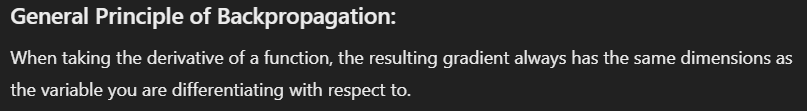

In [ ]:
# loss = -logprobs[range(n), Yb].mean() = -1/n * (prob1 + prob2 + prob3 +...), so:
# ∂Loss/∂logprobs
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
# -------------------------------------------------
# logprobs = probs.log(), and dlog(x)/dx = 1/x, so: 
# ∂Loss/∂probs = ∂logprobs/∂probs * ∂Loss/∂logprobs
dprobs = (1.0/probs) * dlogprobs    # (32, 27) * (32, 27) = (32, 27), same as "probs".
# -------------------------------------------------
# probs = counts * counts_sum_inv
# Remember that Pytorch is also doing broadcasting, so we have to use the chain rule.
# So here we actually have 2 operations in "probs = counts * counts_sum_inv", which is (32, 27) * (32, 1) = (32, 27)
# 1. Inner operation: Element-wise multiplication (32, 27) * (32, 27)
# 2: Outer operation: Broadcasting.
# For 1., since it's just an element-wise multiplication, c = a * b -> ∂c/∂a = b (or "counts" in our case).
# This yields: 
# ∂Loss/∂counts_sum_inv(replicated) = ∂probs/∂counts_sum_inv(replicated) * ∂Loss/∂probs
# Which is:
# dcounts_sum_inv = counts * dprobs             , but it's still with respect to replicated (= broadcasted) counts_sum_inv, so next:
# For 2., it's basically Pytorch reusing the elements of counts_sum_inv (= they are being broadcasted, think of it like in a computational graph)
# and so, the gradients flowing back to the source element have to sum.

# Ex:

# c = a * b, but with tensors (same as probs = counts * counts_sum_inv):
# a[3x3] * b[3,1] = c[3x3] (element-wise)
# =
# a11*b1  a12*b1  a13*b1            # the b elements are contributing to each row, and that is why the sum is row-wise, 
# a21*b2  a22*b2  a23*b2            # because we need to sum the contributions of each part.
# a31*b3  a32*b3  a33*b3

# so:
# ∂Loss/∂counts_sum_inv = ∂probs/∂counts_sum_inv * ∂Loss/∂probs    
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)  # Row sum
# -------------------------------------------------
# ∂Loss/∂counts_sum = ∂counts_sum_inv/∂counts_sum * ∂Loss/∂counts_sum_inv
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv   # (32, 1) * (32, 1) = (32, 1)        , same shape as "counts_sum".

In [70]:
# "counts" is a node that is used twice, once to calc "probs" and once to calc "counts_sum_inv".
# ∂Loss/∂counts = (∂probs/∂counts * ∂Loss/∂probs) + (∂counts_sum/∂counts * ∂counts_sum_inv/∂counts_sum * ∂Loss/∂counts_sum_inv)

# First contribution of "dcounts": (∂probs/∂counts * ∂Loss/∂probs)
dcounts = counts_sum_inv * dprobs   # (32, 1) * (32, 27) w/ broadcasting = (32, 27), same shape as "counts".
# Second contribution: (∂counts_sum/∂counts * ∂counts_sum_inv/∂counts_sum * ∂Loss/∂counts_sum_inv) = (∂counts_sum/∂counts * ∂Loss/∂counts_sum)
dcounts += torch.ones_like(counts) * dcounts_sum    # add contributions

# Ex: 
# counts_sum               =  counts.sum(1, keepdims=True)
#  (32, 1)                 , (32, 27)
# b1 (= a11 + a12 + a13) <--- a11 a12 a13
# b2 (= a21 + a22 + a23) <--- a21 a22 a23
# b3 (= a31 + a32 + a33) <--- a31 a32 a33

#### Second contribution:

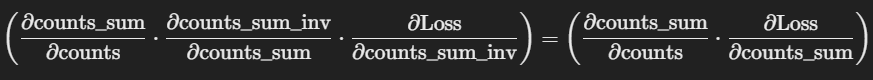

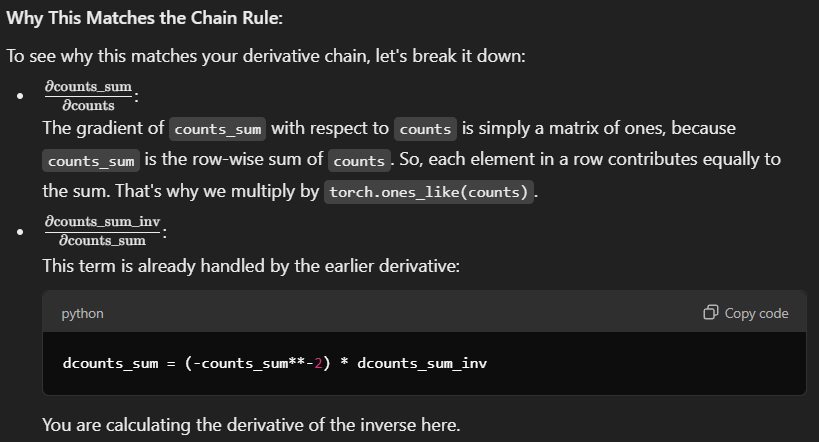

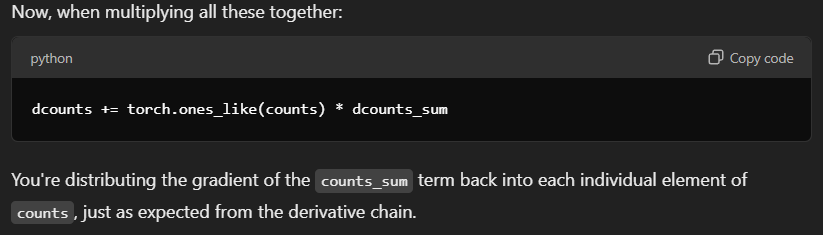

In [71]:
# ∂Loss/∂norm_logits = ∂counts/∂norm_logits * ∂Loss/∂counts
# which is: dnorm_logits = norm_logits.exp() * dcounts
dnorm_logits = counts * dcounts # better since "counts = norm_logits.exp()"

In [ ]:
# ∂Loss/∂logit_maxes = ∂norm_logits/∂logit_maxes * ∂Loss/∂norm_logits
dlogit_maxes = (-1 * dnorm_logits).sum(1, keepdim=True)

# .sum needed again because of broadcasting:

# Ex:

# c11 c12 c13 = a11 a12 a13       b1                            c11 c12 c13 = a11 a12 a13       b1 b1 b1
# c21 c22 c23 = a21 a22 a23   -   b2            --->            c21 c22 c23 = a21 a22 a23   -   b2 b2 b2
# c31 c32 c33 = a31 a32 a33       b3                            c31 c32 c33 = a31 a32 a33       b3 b3 b3

# so e.g. c32 = a32 - b3


# NOTE: Recall that the subtraction of "logit_maxes" from "logits" is done for numerical stability
# so the .exp() does not overflow and that as long as the subtracted value is the same for all 
# elements in 1 row of logits (the probability distribution), "probs" does not change. We therefore expect
# "dlogit_maxes" to be 0 (it is actually very close to 0 due to floating point inaccuracies, but same thing).


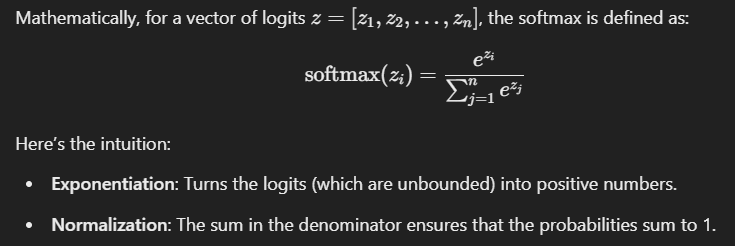

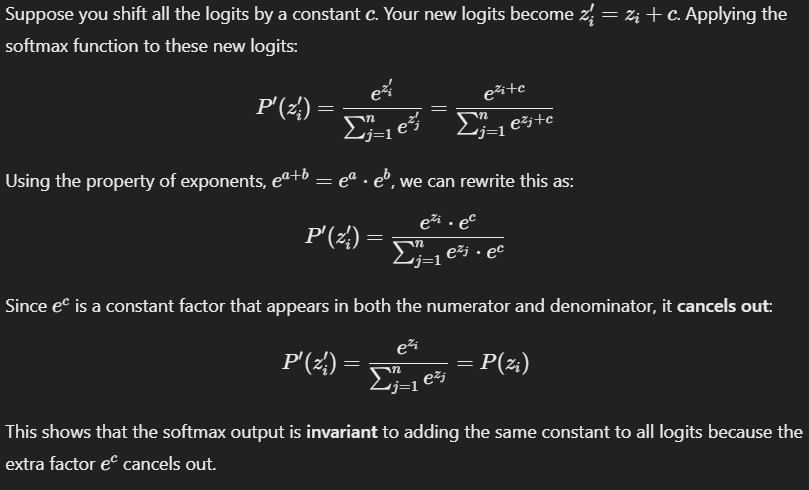

In [73]:
# --------------------------------------------------------------------------------------------------------

#### Connection between logits and probability distributions:

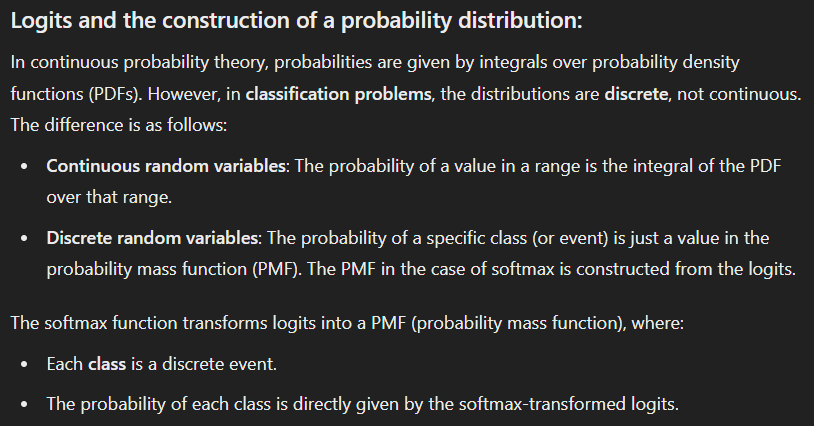

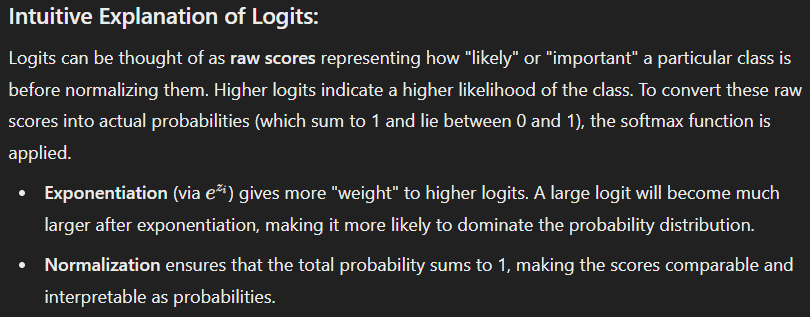

In [74]:
# "Logits" is also a node that is used twice:
# ∂Loss/∂logits = (∂logit_maxes/∂logtis * ∂Loss/∂logit_maxes) + (∂norm_logits/∂logits * ∂Loss/norm_logits)
dlogits = torch.zeros_like(logits).scatter_(1, logits.max(1, keepdim=True).indices, 1) * dlogit_maxes
# We could also achieve the same thing by using F.one_hot or directly scattering "dlogit_maxes".
# "dlogit_maxes" is (32, 1) so it will be broadcasted. In this case, that correctly scatters "dlogit_maxes" where the 1s are.

# ∂norm_logits/∂logits is a tensor of 1s.
dlogits += dnorm_logits

In [75]:
dlogits.shape, h.shape, W2.shape, b2.shape

# (32, 27) = (32, 64) * (64, 27) + (27)     , "dlogits" has the same shape as "logits".

# This means that b2 will be broadcast as follows:

# (32, 64) * (64, 27) = (32, 27)
#                       (    27)    # 1) Pytorch aligns the trailing dimensions.
#                       (1,  27)    # 2) It augments b2's dimensions, turning it into a row vector.
#                       (32, 27)    # 3) The row vector is replicated vertically to form a (32, 27) tensor.

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

##### Use small example to understand the pattern (Very useful strategy in general!):

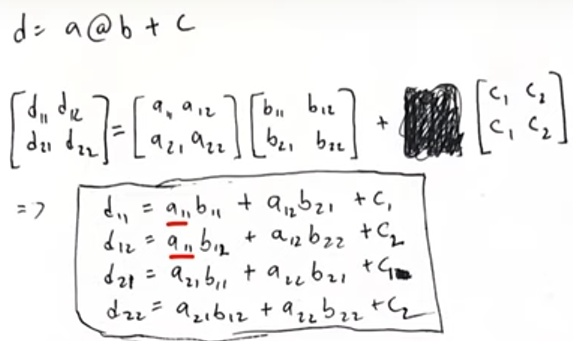

In [76]:
# ∂Loss/∂h = 

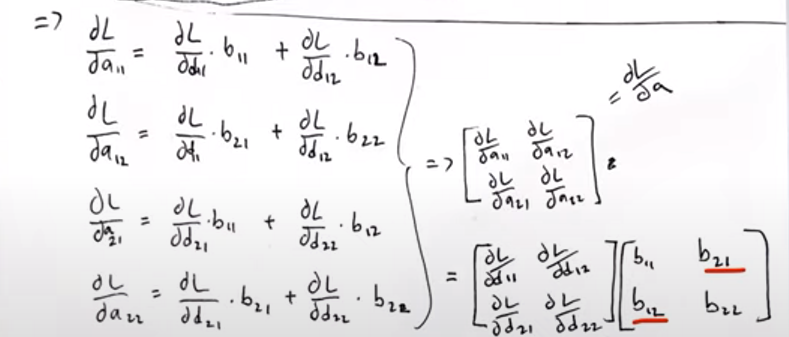

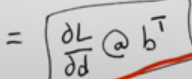

In [77]:
# ∂Loss/∂W =

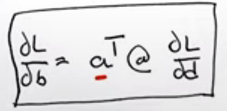

In [78]:
# ∂Loss/∂b =

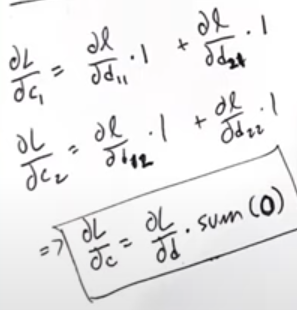

In [79]:
# But there is no need to memorize these formulas or derive them, as we can use the dimensions to guide us:

# Ex:

# 1) The expression for "dh" has to involve the upstream grad, which is ∂Loss/∂logits (which is "dlogits"); and "W2" (the mutliplication partner, since
#    there are no "h" elements involved with "b" elements. Look at the first picture for reference, there h=a and b=c).
# 2) "dh" has to have the same dimensions as "h", which is (32, 64).
# 3) "W2" is (64, 27)
# 4) So "dh = dlogits * W2.T" so the dimensions match.

# The same logic applies to "db2" and "dW2".

In [80]:
dlogits.shape, h.shape, W2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

In [81]:
# ∂Loss/∂h = ∂Loss/∂logits @ ∂logits/∂h
dh = dlogits @ W2.T

# ∂Loss/∂W2 = ∂Loss/∂logits @ ∂logits/∂W2
dW2 = h.T @ dlogits

# ∂Loss/∂b2 = ∂Loss/∂logits * ∂logits/∂b2
db2 = dlogits.sum(0)      # Sum the contributions due to broadcasting. No need for keepdim because b2.shape = (27).

In [82]:
# ∂Loss/∂hpreact = ∂h/∂hpreact * ∂Loss/∂h

# dhpreact = (1 - torch.tanh(hpreact)**2) * dh

dhpreact = (1 - h**2) * dh # better since h = torch.tanh(hpreact) already.

In [83]:
# ∂Loss/∂bngain = ∂hpreact/∂bngain * ∂Loss/hpreact

dbngain = (bnraw * dhpreact).sum(0, keepdim=True)

In [84]:
# ∂Loss/∂bnbias = ∂hpreact/∂bnbias * ∂Loss/hpreact

# dbnbias = (torch.ones_like(hpreact) * dhpreact).sum(0, keepdim=True)

dbnbias = dhpreact.sum(0, keepdim=True) # more efficient way of writing it.

In [85]:
# ∂Loss/∂bnraw = ∂hpreact/∂bnraw * ∂Loss/hpreact

dbnraw =  bngain * dhpreact

In [86]:
# ∂Loss/∂bnvar_inv = ∂bnraw/∂bnvar_inv * ∂Loss/∂bnraw

dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim = True)

In [87]:
# ∂Loss/∂bnvar = ∂dbnvar_inv/∂bnvar * ∂Loss/∂bnvar_inv

dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv

In [88]:
# ∂Loss/∂bndiff2 = ∂bnvar/∂bndiff2 * ∂Loss/∂bnvar

dbndiff2 = 1/(n-1) * dbnvar

In [89]:
# ∂Loss/∂bndiff = (∂bnraw/∂bndiff * ∂Loss/∂bnraw) + (∂bndiff2/∂bndiff * ∂Loss/∂bndiff2)

dbndiff = bnvar_inv * dbnraw
dbndiff += 2 * bndiff * dbndiff2

In [90]:
# ∂Loss/∂bnmeani = ∂bndiff/∂bnmeani * ∂Loss/∂bndiff

dbnmeani = (-torch.ones_like(bnmeani) * dbndiff).sum(0, keepdim=True)

In [91]:
# ∂Loss/∂hprebn = (∂bndiff/∂hprebn * ∂Loss/∂bndiff) + (∂bnmeani/∂hprebn * ∂Loss/∂bnmeani)

dhprebn = torch.ones_like(hprebn) * dbndiff
dhprebn += 1/n * dbnmeani

In [92]:
# ∂Loss/∂embcat = ∂Loss/∂hprebn @ ∂hprebn/∂embcat

dembcat = dhprebn @ W1.T

# ∂Loss/∂W1 = ∂Loss/∂hprebn @ ∂hprebn/∂W1

dW1 = embcat.T @ dhprebn

# ∂Loss/∂W1 = ∂Loss/∂hprebn @ ∂hprebn/∂b1

db1 = dhprebn.sum(0, keepdim=True)

In [93]:
# ∂Loss/∂emb = ∂embcat/∂emb * ∂Loss/∂embcat

# demb = torch.ones_like(emb) * dembcat.view(emb.shape[0], emb.shape[1], emb.shape[2])

demb = dembcat.view(emb.shape[0], emb.shape[1], emb.shape[2]) # or more efficiently written.

In [94]:
# ∂Loss/∂C = ∂emb/∂C * ∂Loss/∂emb

# For dC we essentially need to route the upstream gradients from demb into dC depending on which character they belong to, and adding in case of multiple occurences:

dC = torch.zeros_like(C)

for k in range(Xb.shape[0]):        # Go through the whole Xb, which is the tensor of indices of each sample in the minibatch
    for j in range(Xb.shape[1]):
        ix  = Xb[k,j]    # ix is a row index of C, which corresponds to the embeddings for each character. Remember C is (27 chars, 10 embeds).
        dC[ix] += demb[k,j]

In [95]:
# Loss with manual Softmax
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
# 2nd Layer
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
# Activation function of 1st layer (tanh)
cmp('hpreact', dhpreact, hpreact)
# 1st layer's BatchNorm layer
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
# 1st layer
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
# Embedding
cmp('emb', demb, emb)
cmp('C', dC, C)


logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

# 3) Analytical Backpropagation

## Exercise 2: cross_entropy Backpropagation

In [96]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.320498466491699 diff: 0.0


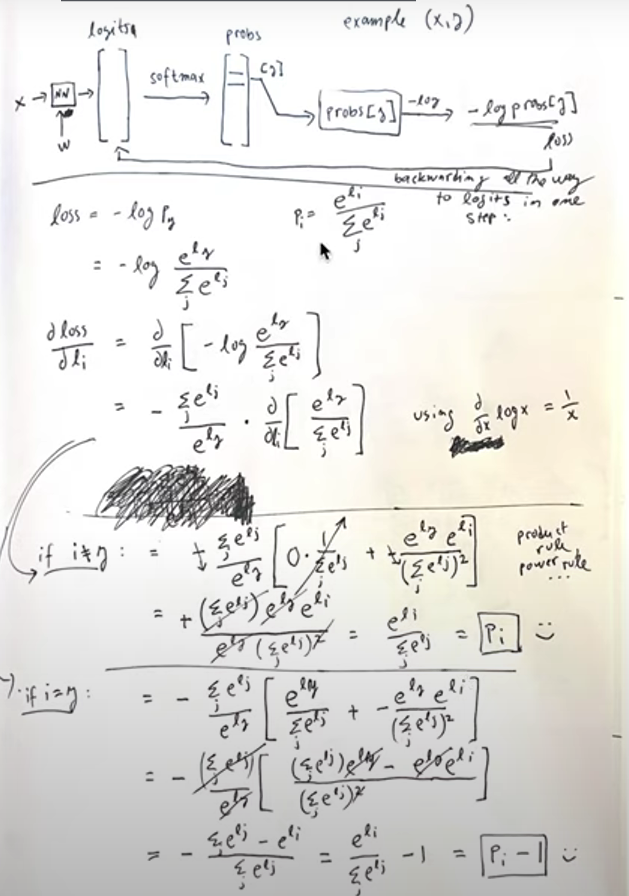

In [97]:
# backward pass

# ∂Loss/∂logits =
dlogits = F.softmax(logits, 1)  # could also do "dlogits = probs", since "probs" is the Softmax of "logits".
dlogits[range(n), Yb] -= 1      # As per the two cases above.
dlogits /= n                    # Since the loss is averages over the batch.


cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 8.847564458847046e-09


In [98]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [99]:
# For inspection and interpretation:

print(f'Softmax first row:\n{F.softmax(logits, 1)[0]}, \n\ndlogits first row:\n{dlogits[0]*n}')   # "dlogits" scaled back by n for interpretability.

Softmax first row:
tensor([0.0759, 0.0907, 0.0185, 0.0481, 0.0184, 0.0787, 0.0257, 0.0359, 0.0182,
        0.0304, 0.0383, 0.0388, 0.0374, 0.0263, 0.0357, 0.0143, 0.0092, 0.0195,
        0.0162, 0.0540, 0.0528, 0.0193, 0.0247, 0.0693, 0.0576, 0.0249, 0.0210],
       grad_fn=<SelectBackward0>), 

dlogits first row:
tensor([ 0.0759,  0.0907,  0.0185,  0.0481,  0.0184,  0.0787,  0.0257,  0.0359,
        -0.9818,  0.0304,  0.0383,  0.0388,  0.0374,  0.0263,  0.0357,  0.0143,
         0.0092,  0.0195,  0.0162,  0.0540,  0.0528,  0.0193,  0.0247,  0.0693,
         0.0576,  0.0249,  0.0210], grad_fn=<MulBackward0>)


F.softmax(logits, 1)[0].sum().item() = 1.0, 
dlogits[0].sum().item() = -1.6298145055770874e-09


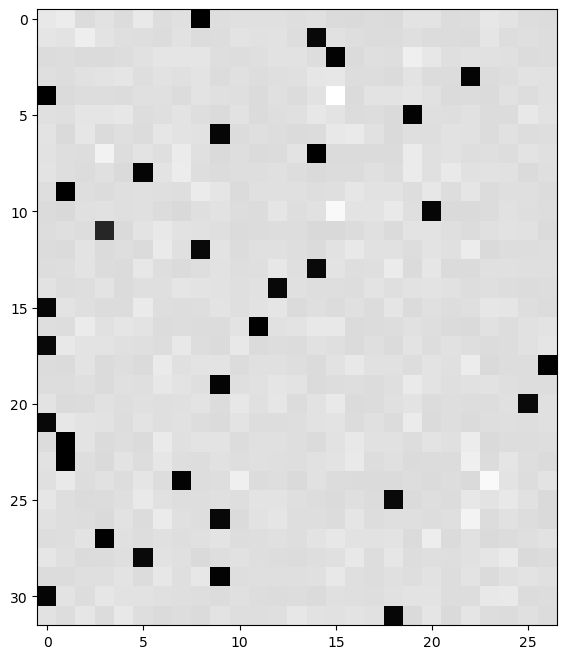

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray');

# NOTE: below is a graph of dlogits. The black squares represent the gradients at the correct label,
# and they are black because the backward pass assigned larger 
# magnitudes to those gradients, effectively acting as a steering force.

print(f'{F.softmax(logits, 1)[0].sum().item() = }, \n{dlogits[0].sum().item() = }')

## Exercise 3: BatchNorm Backpropagation

In [ ]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # NOTE: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate ∂hpreact/∂hprebn (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)


dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0))

# NOTE: Remember this formula is per neuron.

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


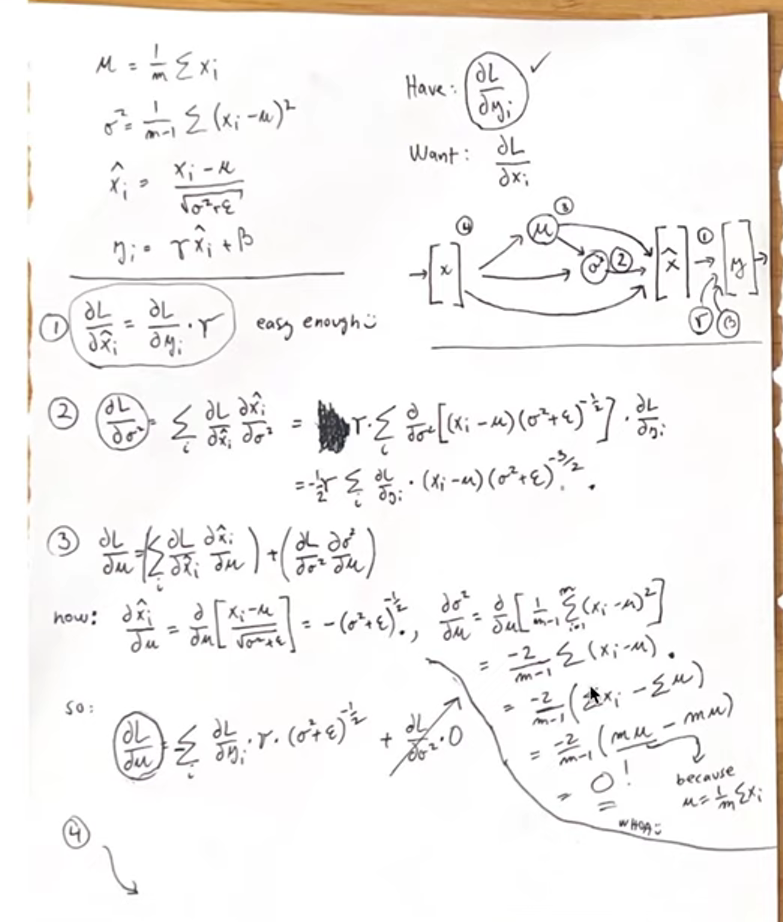

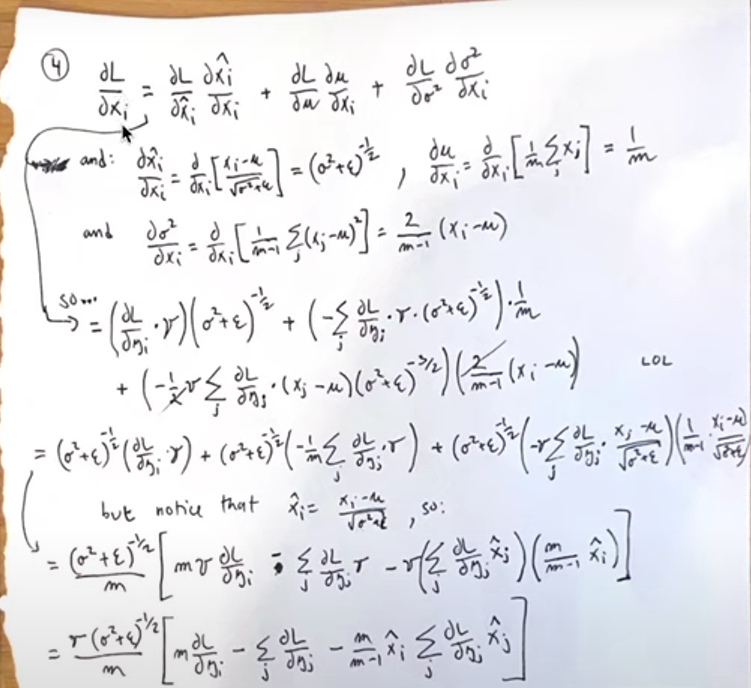

## Exercise 4: Neural Net Training with Manual Backpropagation

In [122]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  # Output layer backprop:      # Loss function between output of 2nd layer and output logits (includes softmax)
  dlogits = F.softmax(logits, 1)  
  dlogits[range(n), Yb] -= 1     
  dlogits /= n            
  # 2nd layer backprop:
  dh = dlogits @ W2.T
  dW2 = h.T @ dlogits
  db2 = dlogits.sum(0)      
  # tanh backprop:              # Remember tanh is the activation function of the 1st layer.
  dhpreact = (1 - h**2) * dh
  # BatchNorm backprop:         # BatchNorm layer between 1st layer activation function and 1st layer linear transform.
  dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
  dbnbias = dhpreact.sum(0, keepdim=True)
  dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0))
  # 1st layer backprop:
  dembcat = dhprebn @ W1.T
  dW1 = embcat.T @ dhprebn
  db1 = dhprebn.sum(0, keepdim=True)
  # Embedding backprop:
  demb = dembcat.view(emb.shape[0], emb.shape[1], emb.shape[2]) # Backprop through tensor reshaping operation.
  dC = torch.zeros_like(C)                                      # Backprop through embedding lookup operation.
  for k in range(Xb.shape[0]):                                  
      for j in range(Xb.shape[1]):
          ix  = Xb[k,j]    
          dC[ix] += demb[k,j]

  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]  # Compiled computed grads to direct the updates in the update step.
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    #p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    break

12297
      0/ 200000: 3.7983


In [ ]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
    cmp(str(tuple(p.shape)), g, p)

# NOTE: the manually computed gradients are essentially the same as the ones computed internally by Pytorch in loss.backward()

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.0244548320770264e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(200,)          | exact: False | approximate: True  | maxdiff: 3.6088749766349792e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 2.2351741790771484e-08
(27,)           | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(1, 200)        | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09


### Without relying on Pytorch at all now:

In [118]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.7872
  10000/ 200000: 2.1598
  20000/ 200000: 2.4095
  30000/ 200000: 2.4384
  40000/ 200000: 1.9695
  50000/ 200000: 2.3430
  60000/ 200000: 2.4310
  70000/ 200000: 2.0472
  80000/ 200000: 2.3868
  90000/ 200000: 2.0896
 100000/ 200000: 1.9379
 110000/ 200000: 2.2939
 120000/ 200000: 1.9988
 130000/ 200000: 2.4994
 140000/ 200000: 2.2842
 150000/ 200000: 2.1703
 160000/ 200000: 1.9775
 170000/ 200000: 1.8073
 180000/ 200000: 1.9715
 190000/ 200000: 1.9036


In [119]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [120]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0705440044403076
val 2.10780668258667


In [121]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
mad.
rylle.
emmadiendraegan.
ched.
elin.
shi.
jenleigh.
estanaraelyzion.
kamin.
shubergihirael.
kindreelynn.
novalayus.
macder.
yarulyeh.
yuma.
myson.
daihan.
